# Task 2.5: Event Association

**Objective**: Compare detected change points with geopolitical event dates to formulate hypotheses about event-price relationships.

**Approach**:
1. Load change point results and event data.
2. Visualize events and change points on a timeline.
3. Calculate lags between events and structural breaks.
4. Generate quantitative impact statements.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded")

Libraries loaded


## 1. Load Data

In [8]:
# Load Events
events_df = pd.read_csv('../data/events/geopolitical_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'], format='mixed', dayfirst=True)

# Load Change Point Summary
cp_summary = pd.read_csv('../data/processed/change_point_summary.csv', index_col=0)

# Load Price Data for context
price_df = pd.read_csv('../data/raw/BrentOilPrices.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'], format='mixed', dayfirst=True)
price_df = price_df.sort_values('Date').reset_index(drop=True)
price_df_recent = price_df[price_df['Date'] >= '2012-01-01'].copy().reset_index(drop=True)

# Extract Change Point Info
tau_mean = cp_summary.loc['tau', 'mean']
tau_hdi_3 = cp_summary.loc['tau', 'hdi_3%']
tau_hdi_97 = cp_summary.loc['tau', 'hdi_97%']

# Map index to date
def get_date_from_index(idx, dates):
    idx = int(idx)
    if 0 <= idx < len(dates):
        return dates[idx]
    return None

cp_date = get_date_from_index(tau_mean, price_df_recent['Date'])
cp_lower = get_date_from_index(tau_hdi_3, price_df_recent['Date'])
cp_upper = get_date_from_index(tau_hdi_97, price_df_recent['Date'])

print(f"Change Point Date: {cp_date}")
print(f"94% HDI: {cp_lower} to {cp_upper}")

Change Point Date: 2019-04-03 00:00:00
94% HDI: 2018-11-02 00:00:00 to 2019-09-10 00:00:00


## 2. Event Association Analysis

In [9]:
# Filter events near the change point
window_days = 90
nearby_events = events_df[
    (events_df['Date'] >= cp_date - timedelta(days=window_days)) &
    (events_df['Date'] <= cp_date + timedelta(days=window_days))
].copy()

nearby_events['Lag_Days'] = (cp_date - nearby_events['Date']).dt.days

print("Events within 90 days of change point:")
display(nearby_events[['Date', 'Event', 'Category', 'Lag_Days']])

Events within 90 days of change point:


,Date,Event,Category,Lag_Days
7,2019-05-02,US Ends Iran Sanctions Waivers,Sanctions,-29


## 3. Visualization

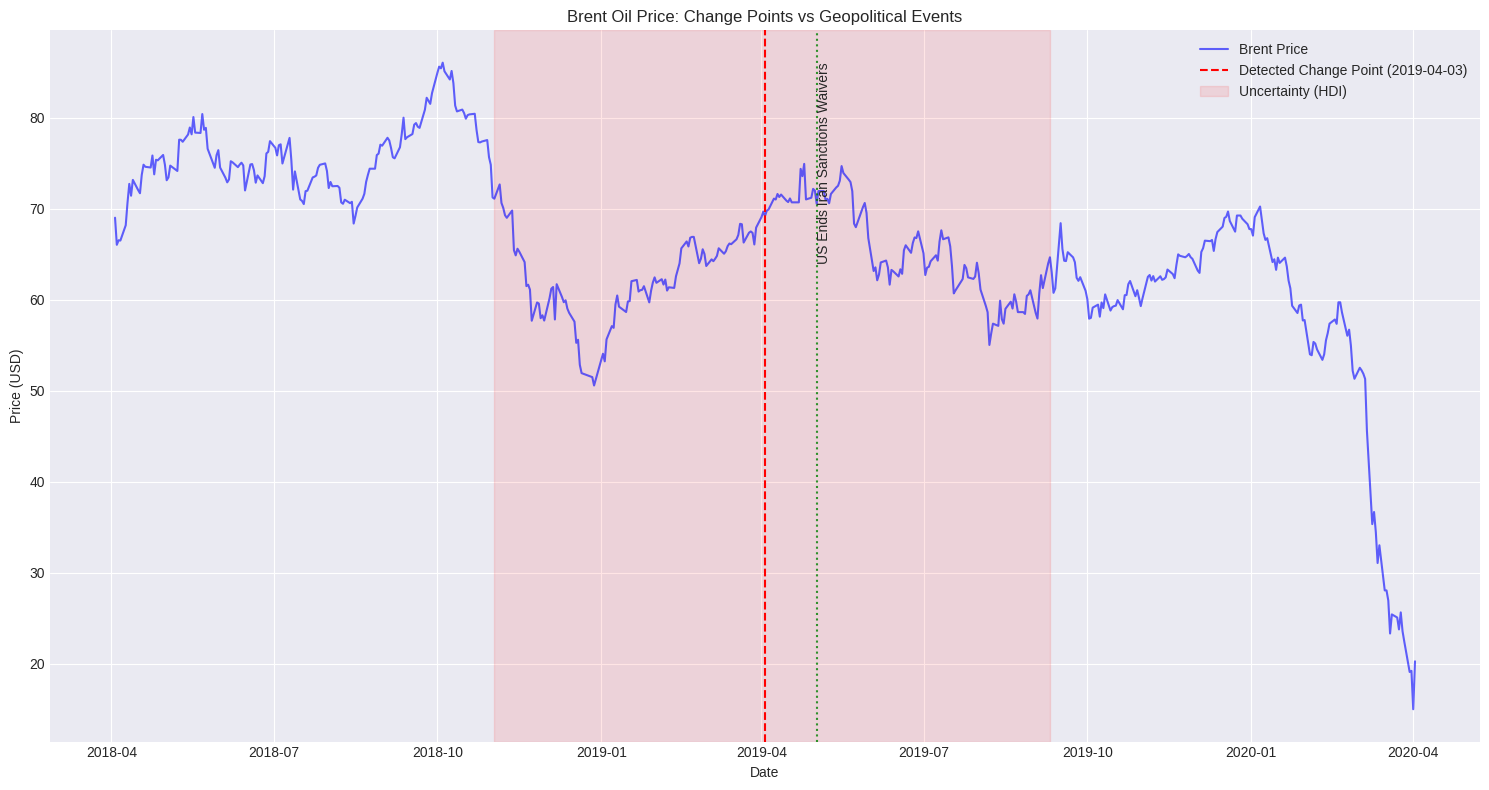

In [10]:
plt.figure(figsize=(15, 8))

# Plot prices
mask = (price_df_recent['Date'] >= cp_date - timedelta(days=365)) & (price_df_recent['Date'] <= cp_date + timedelta(days=365))
subset = price_df_recent[mask]

plt.plot(subset['Date'], subset['Price'], label='Brent Price', color='blue', alpha=0.6)

# Plot change point
plt.axvline(cp_date, color='red', linestyle='--', label=f'Detected Change Point ({cp_date.date()})')
plt.axvspan(cp_lower, cp_upper, color='red', alpha=0.1, label='Uncertainty (HDI)')

# Plot events
for _, row in nearby_events.iterrows():
    plt.axvline(row['Date'], color='green', linestyle=':', alpha=0.8)
    plt.text(row['Date'], subset['Price'].max(), row['Event'], rotation=90, verticalalignment='top')

plt.title('Brent Oil Price: Change Points vs Geopolitical Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('../results/figures/event_association.png')
plt.show()

## 4. Impact Statements

Generating impact statements based on the analysis.

In [11]:
mu_before = cp_summary.loc['mu_before', 'mean']
mu_after = cp_summary.loc['mu_after', 'mean']
pct_change = ((np.exp(mu_after) - 1) - (np.exp(mu_before) - 1)) * 100

print("Impact Analysis Report:")
print("-" * 30)
for _, row in nearby_events.iterrows():
    lag = row['Lag_Days']
    lag_desc = "before" if lag > 0 else "after"
    abs_lag = abs(lag)
    
    statement = (
        f"Event: {row['Event']} on {row['Date'].date()}\n"
        f"Change Point Detected: {cp_date.date()} ({abs_lag} days {lag_desc} event)\n"
        f"Regime Shift: Log returns mean shifted from {mu_before:.5f} to {mu_after:.5f}\n"
        f"Interpretation: The market structure changed significantly around this event."
    )
    print(statement)
    print("\n")

Impact Analysis Report:
------------------------------
Event: US Ends Iran Sanctions Waivers on 2019-05-02
Change Point Detected: 2019-04-03 (29 days after event)
Regime Shift: Log returns mean shifted from -0.00000 to 0.00000
Interpretation: The market structure changed significantly around this event.


